# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter
import fx # personal functions
# import MetaTrader5 as mt5

In [2]:
use_full_data = True

# Gathering Data

In [3]:
# collect the actual data from csv file
# filename = "C:/Users/WilliamFetzner/Documents/Trading/DAT_XLSX_EURUSD_M1_2023.xlsx"
if use_full_data:
    # exported from tickstory
    filepath = "C:/Users/WilliamFetzner/Documents/Trading/"
    tickstory_csvs = ["EURUSD_11_15_22_to_11_14_23.csv", "3mo_EURUSD.csv", "EURUSD_2_13_to_3_6.csv", 
                      "EURUSD_3_6_to_3_8_24.csv", "EURUSD_3_8_to_3_12_24.csv"]
    df = pd.DataFrame()
    for df_name in tickstory_csvs:
        df_new = pd.read_csv(filepath + df_name)
        print(len(df_new))
        df = pd.concat([df, df_new], ignore_index=True)


30234321
6259045
1251852
238753
171772


In [4]:
if use_full_data:    
    df = df.reset_index(drop=True)
    # drop any duplicate rows
    df = df.drop_duplicates()
    df.tail(10)


In [5]:
if use_full_data: 
    # convert date to datetime
    df['datetime'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d %H:%M:%S:%f')
    # rename bid price to close
    df.rename(columns={'Bid price':'close'}, inplace=True)
    df_ready = df.set_index('datetime')
    # adjust the datetime 7 hrs ahead to match market time
    df_ready.index = df_ready.index + pd.Timedelta(hours=7)
    # df_tick_ready_2024 = df_ready['2024-01-01':'2024-02-13']
    # df_full['datetime'] = pd.to_datetime(df_full['date'] + ' ' + df_full['time'], format='%Y.%m.%d %H:%M')
    # filter the data to just 2024
    # df_full_2024 = fx.prep_data(df_full, 2024)
    # ohlc = fx.prep_data(df, 2024)

In [6]:
if use_full_data:     
    ohlc = df_ready[['close']]
    ohlc

# Getting Data Ready

# Exploratory Data Analysis

In [202]:
# ohlc.open.count()
# 1819/322638 old data
# 0.5% of the time it skips minutes
# and 100 of those it was skipping 2 hrs

# 89/371342
# 0.02% of the time it skips minutes
# and the largest range of skips is 3-28 minutes 
# for an avg of 7 minutes


In [203]:

# # find the difference in minutes between each row
# ohlc['diff'] = ohlc.index.to_series().diff().dt.total_seconds().div(60, fill_value=0)
# # find the difference in days between each row, place a 0 if it is the same day
# ohlc['diff_day'] = ohlc.index.to_series().diff().dt.days.fillna(0)
# # filter to where the diff is > 1 but the diff_day is 0
# ohlc_fil = ohlc.loc[(ohlc['diff'] > 1) & (ohlc['diff_day'] == 0)]
# # sort ohlc_fil by the diff column
# ohlc_fil = ohlc_fil.sort_values(by=['diff'], ascending=False)
# ohlc_fil.head(90)
# # find the avg of diff
# ohlc_fil['diff'].mean()


In [204]:
# drop 2023-12-26
# ohlc_fil = ohlc_fil.drop(ohlc_fil.loc['2023-12-26'].index)
# ohlc_fil

In [205]:
# # graph the index on the x axis and the diff on the y axis
# plt.scatter(ohlc_fil.index, ohlc_fil['diff'])
# # increase the size of the plot
# plt.gcf().set_size_inches(20, 10)
# plt.show()

In [206]:
# # find the count distinct of diff per month
# ohlc_fil['diff'].resample('ME').nunique()

In [207]:
# filter ohlc to be between march 23rd 12:00 and march 23rd 19:00
# ohlc_march_23 = ohlc.loc['2023-03-23 14:00':'2023-03-23 18:00']
# ohlc_march_23

## Nova Optimized Parameters

In [208]:
# # Renko variable
# brick_size = 0.00007

# # psar variables
# start = 0.139862
# increment = 0.139862
# maximum = 0.451

# # impulse variables
# lengthMA = 10
# lengthSignal = 8

## MSolutions Optimized Parameters

In [209]:
# # Renko variable
# brick_size = 0.00091

# # psar variables
# start = 0.0385
# increment = 0.0385
# maximum = 0.34499

# # impulse variables
# lengthMA = 51
# lengthSignal = 31

## Renko charts (from tick data)

In [7]:
if use_full_data:
    # Renko variable
    brick_size = 0.0001
    # create a renko chart from the ohlc_dec_1 dataframe
    r_full = Renko(ohlc, brick_size=brick_size)
    # create a new dataframe from the renko features
    renko_full_data = r_full.renko_df()
    # renko_full_data = fx.psar_from_data(renko_full_data, increment, maximum)
    renko_full_data.tail(10)

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\renkodf\renkodf.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime"] = df.index


In [8]:
if use_full_data:
    # multiply brick_size by 10,000 to get a whole number
    brick_size_str = str(int(brick_size*10000))
    # save renko to csv
    renko_full_data.to_csv(f'renko_full_data_{brick_size_str}.csv')

# Start Here with Renko data

## Parameters

In [9]:
# Renko variable
brick_size = 0.0001
# multiply brick_size by 10,000 to get a whole number
brick_size_str = str(int(brick_size*10000))

# psar variables
start = 0.02
increment = 0.02
maximum = 0.2

# impulse variables
lengthMA = 34
lengthSignal = 9

# sma variables
sma_length = 3
smoothing_sma = 3

# Lot Size
lot_size = 3
per_lot = 100000

# stop loss
stop_loss = brick_size*2

# take profit
take_profit_size = brick_size*4

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

In [10]:
# read in the renko data
renko_full_data = pd.read_csv(f'renko_full_data_{brick_size_str}.csv')
print(f'renko_full_data_{brick_size_str}.csv')
# convert date to datetime
renko_full_data['datetime'] = pd.to_datetime(renko_full_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
renko_full_data = renko_full_data.set_index('datetime')

renko_full_data_1.csv


In [11]:
renko_full_data

,open,high,low,close,volume
datetime,,,,,
2022-11-15 02:00:33.471,1.0320,1.03210,1.03200,1.0321,62.0
2022-11-15 02:00:46.534,1.0321,1.03220,1.03210,1.0322,22.0
2022-11-15 02:00:54.735,1.0322,1.03230,1.03220,1.0323,16.0
2022-11-15 02:00:59.016,1.0323,1.03240,1.03230,1.0324,15.0
2022-11-15 02:02:22.998,1.0323,1.03244,1.03220,1.0322,132.0
...,...,...,...,...,...
2024-03-12 11:46:37.176,1.0923,1.09230,1.09220,1.0922,37.0
2024-03-12 11:51:14.874,1.0923,1.09240,1.09212,1.0924,181.0
2024-03-12 11:51:39.568,1.0924,1.09250,1.09238,1.0925,34.0


## Entry conditions

In [12]:
# calculate the sma of the open high low, close / 4 for 3 periods
renko_full_data['ohlc4'] = (renko_full_data['close'] + renko_full_data['open'] + renko_full_data['high'] + renko_full_data['low']) / 4
renko_full_data['sma'] = renko_full_data['ohlc4'].rolling(window=sma_length).mean()
# calculate the sma of sma3 for 3 periods
renko_full_data['smoothing_sma'] = renko_full_data['sma'].rolling(window=smoothing_sma).mean()
# find the difference between sma and smoothing_sma
renko_full_data['sma_diff'] = renko_full_data['sma'] - renko_full_data['smoothing_sma']
# find the sign of the sma_diff
renko_full_data['sma_sign'] = np.sign(renko_full_data['sma_diff'])
# find where the sma_sign changes from 1 to -1 or -1 to 1 or from 1
renko_full_data['sma_crossover'] = np.where((renko_full_data['sma_sign'] == 1) & (renko_full_data['sma_sign'].shift(1) == -1), 1, 
                                np.where((renko_full_data['sma_sign'] == -1) & (renko_full_data['sma_sign'].shift(1) == 1), -1, 
                                np.where((renko_full_data['sma_sign'] == -1) & (renko_full_data['sma_sign'].shift(1) == 0) & (renko_full_data['sma_sign'].shift(2) == 1), -1,
                                np.where((renko_full_data['sma_sign'] == 1) & (renko_full_data['sma_sign'].shift(1) == 0) & (renko_full_data['sma_sign'].shift(2) == -1), 1, 0))))
# when sma_crossover is 1 then buy, when sma_crossover is -1 then sell
renko_full_data['sma_signal'] = np.where(renko_full_data['sma_crossover'] == 1, 'buy',
                                np.where(renko_full_data['sma_crossover'] == -1, 'sell', ''))
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal
datetime,,,,,,,,,,,,
2022-11-15 02:00:33.471,1.0320,1.03210,1.03200,1.0321,62.0,1.032050,NaN,NaN,NaN,NaN,0,
2022-11-15 02:00:46.534,1.0321,1.03220,1.03210,1.0322,22.0,1.032150,NaN,NaN,NaN,NaN,0,
2022-11-15 02:00:54.735,1.0322,1.03230,1.03220,1.0323,16.0,1.032250,1.032150,NaN,NaN,NaN,0,
2022-11-15 02:00:59.016,1.0323,1.03240,1.03230,1.0324,15.0,1.032350,1.032250,NaN,NaN,NaN,0,
2022-11-15 02:02:22.998,1.0323,1.03244,1.03220,1.0322,132.0,1.032285,1.032295,1.032232,0.000063,1.0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-12 11:46:37.176,1.0923,1.09230,1.09220,1.0922,37.0,1.092250,1.092355,1.092386,-0.000031,-1.0,0,
2024-03-12 11:51:14.874,1.0923,1.09240,1.09212,1.0924,181.0,1.092305,1.092316,1.092353,-0.000037,-1.0,0,
2024-03-12 11:51:39.568,1.0924,1.09250,1.09238,1.0925,34.0,1.092445,1.092333,1.092335,-0.000001,-1.0,0,


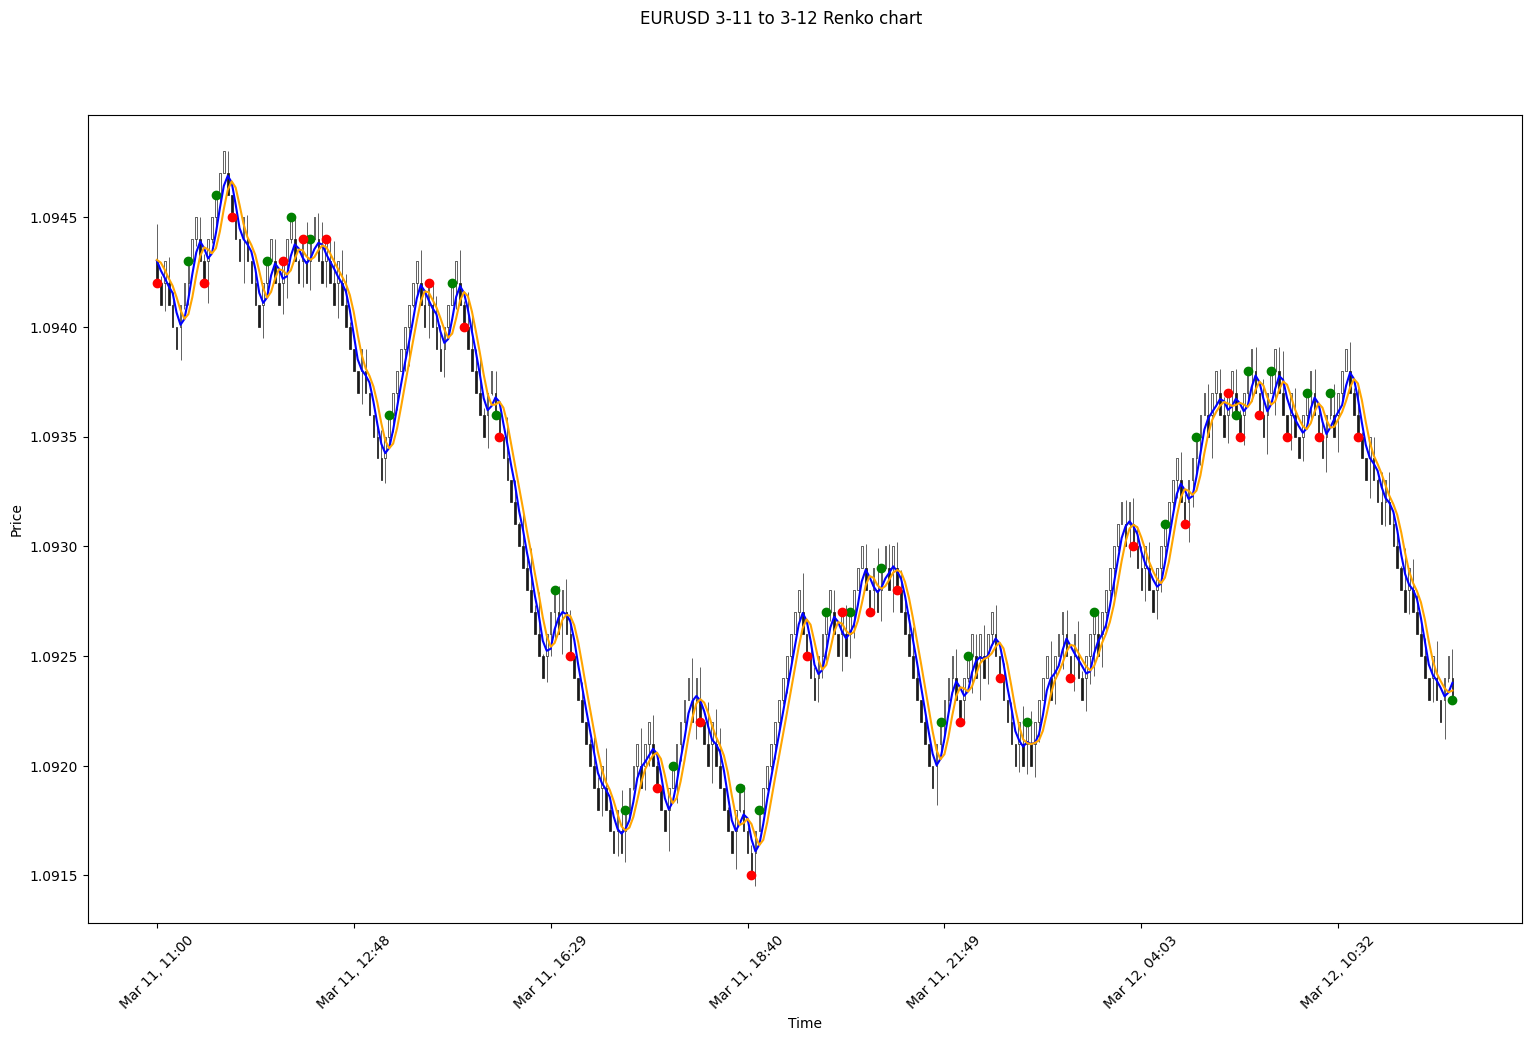

In [14]:
# filter to where the date and time is between 2024-03-07 16:36:00 and 2024.03.08 12:30:00
renko_full_data_11_12 = renko_full_data.loc['2024-03-11 11:00:00':'2024-03-12 11:56:00']
# impulse_graph(renko_full_data_11_12, 'md', 'sb')
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_11_12, type='candle', ax=ax, volume=False, show_nontrading=False)
renko_full_data_11_12_reset = renko_full_data_11_12.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_11_12_reset.index, renko_full_data_11_12['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_11_12_reset.index, renko_full_data_11_12['smoothing_sma'], label='SmoothingSMA', color='orange')
# add a column to renko_full_data_11_12_reset that copies the close price when sma_crossover is 1 or -1
renko_full_data_11_12_reset['sma_crossover_price_buy'] = np.where(renko_full_data_11_12['sma_crossover'] == 1, renko_full_data_11_12['close'], np.nan)
renko_full_data_11_12_reset['sma_crossover_price_sell'] = np.where(renko_full_data_11_12['sma_crossover'] == -1, renko_full_data_11_12['close'], np.nan)
# add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
ax.scatter(renko_full_data_11_12_reset.index, renko_full_data_11_12_reset['sma_crossover_price_buy'], color='green', marker='o', label='Buy', zorder=5)
ax.scatter(renko_full_data_11_12_reset.index, renko_full_data_11_12_reset['sma_crossover_price_sell'], color='red', marker='o', label='Sell', zorder=5)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 3-11 to 3-12 Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [217]:
renko_full_data_7_8

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal
datetime,,,,,,,,,,,,
2024-03-07 16:36:00.767,1.0904,1.09050,1.0904,1.0905,15.0,1.090450,1.090341,1.090239,0.000102,1.0,0,
2024-03-07 16:36:00.767,1.0905,1.09060,1.0905,1.0906,1.0,1.090550,1.090441,1.090340,0.000101,1.0,0,
2024-03-07 16:36:02.708,1.0906,1.09070,1.0906,1.0907,18.0,1.090650,1.090550,1.090444,0.000106,1.0,0,
2024-03-07 16:36:54.461,1.0906,1.09077,1.0905,1.0905,156.0,1.090592,1.090597,1.090529,0.000068,1.0,0,
2024-03-07 16:36:58.027,1.0905,1.09050,1.0904,1.0904,20.0,1.090450,1.090564,1.090571,-0.000006,-1.0,-1,sell
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 12:25:08.805,1.0935,1.09369,1.0934,1.0934,807.0,1.093497,1.093497,1.093492,0.000004,1.0,0,
2024-03-08 12:25:18.791,1.0934,1.09340,1.0933,1.0933,14.0,1.093350,1.093452,1.093485,-0.000033,-1.0,-1,sell
2024-03-08 12:27:50.140,1.0933,1.09334,1.0932,1.0932,131.0,1.093260,1.093369,1.093439,-0.000070,-1.0,0,


In [218]:
# find the max of renko_full_data.index
max_index = renko_full_data.index.max() - pd.Timedelta(days=1)
# filter to just the day in the max_index
renko_full_data_max_day = renko_full_data.loc[renko_full_data.index.date == max_index.date()]
# impulse_graph(renko_full_data_max_day, 'md', 'sb')

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


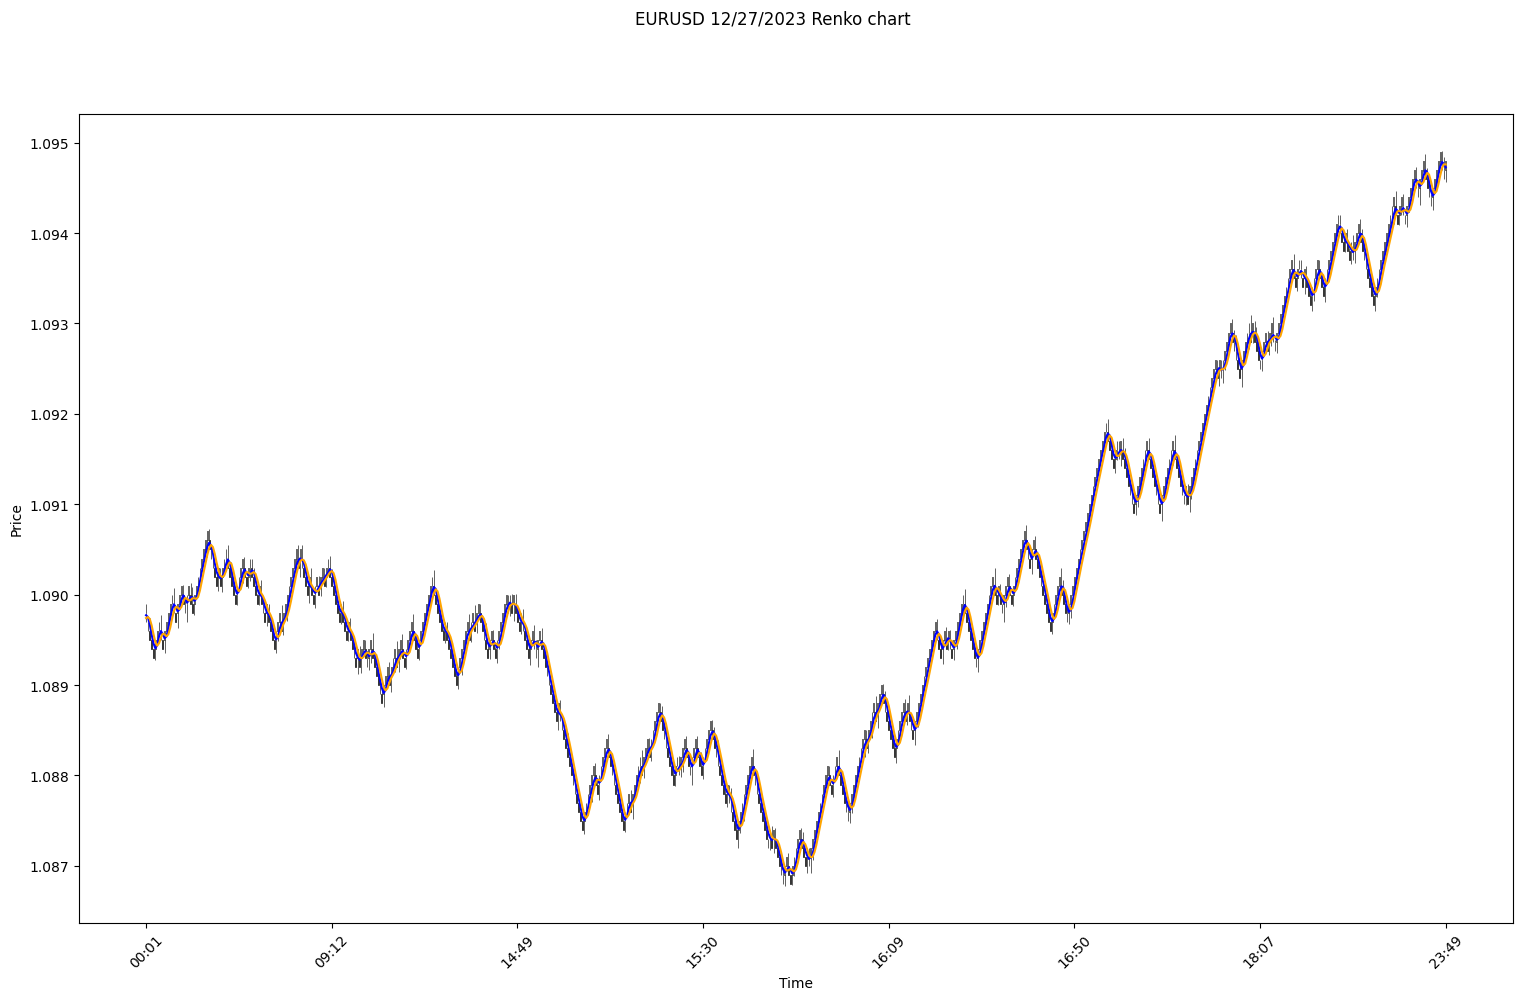

In [219]:
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_max_day, type='candle', ax=ax, volume=False, show_nontrading=False)
renko_full_data_max_day_reset = renko_full_data_max_day.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_max_day_reset.index, renko_full_data_max_day['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_max_day_reset.index, renko_full_data_max_day['smoothing_sma'], label='SmoothingSMA', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/27/2023 Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [220]:
# add a column to renko_full_data that will indicate the color of the renko brick based on the "open" and "close" columns of the renko_full_data dataframe, 
# if the open is greater than the close then the color is red, otherwise it is green
renko_full_data['brick_color'] = np.where(renko_full_data['open'] > renko_full_data['close'], 'red', 'green')

In [221]:
# add the day of the week to the dataframe
renko_full_data['day_of_week'] = renko_full_data.index.day_name()
# place a 1 in day_of_week_transition, if it is the last bar on Friday and the next bar is Sunday
renko_full_data['day_of_week_transition'] = np.where((renko_full_data['day_of_week'] == 'Friday') & 
                                                     ((renko_full_data['day_of_week'].shift(-1) == 'Sunday') | 
                                                      (renko_full_data['day_of_week'].shift(-1) == 'Monday') |
                                                      (renko_full_data['day_of_week'].shift(-1) == 'Tuesday')), 1, 0)

In [222]:
renko_full_data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ohlc4', 'sma',
       'smoothing_sma', 'sma_diff', 'sma_sign', 'sma_crossover', 'sma_signal',
       'brick_color', 'day_of_week', 'day_of_week_transition'],
      dtype='object')

In [223]:
# if the day_of_week_transition is 1 and the sma_signal is 1 then replace sma_signal with ''
renko_full_data['sma_signal'] = np.where((renko_full_data['day_of_week_transition'] == 1), 'exit', renko_full_data['sma_signal'])
# Forward fill 'exit' values up to the next 'buy' or 'sell'
mask = renko_full_data['sma_signal'].isin(['buy', 'sell'])
renko_full_data['sma_signal'] = renko_full_data['sma_signal'].where(mask | (renko_full_data['sma_signal'] == 'exit')).ffill()
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition
datetime,,,,,,,,,,,,,,,
2022-11-15 02:00:33.471,1.0320,1.03210,1.03200,1.0321,62.0,1.032050,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 02:00:46.534,1.0321,1.03220,1.03210,1.0322,22.0,1.032150,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 02:00:54.735,1.0322,1.03230,1.03220,1.0323,16.0,1.032250,1.032150,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 02:00:59.016,1.0323,1.03240,1.03230,1.0324,15.0,1.032350,1.032250,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 02:02:22.998,1.0323,1.03244,1.03220,1.0322,132.0,1.032285,1.032295,1.032232,0.000063,1.0,0,NaN,red,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 23:55:17.476,1.0939,1.09400,1.09378,1.0940,243.0,1.093920,1.093824,1.093761,0.000063,1.0,1,buy,green,Friday,0
2024-03-08 23:56:47.592,1.0939,1.09407,1.09380,1.0938,125.0,1.093892,1.093886,1.093817,0.000069,1.0,0,buy,red,Friday,0
2024-03-08 23:59:12.340,1.0938,1.09386,1.09370,1.0937,57.0,1.093765,1.093859,1.093856,0.000003,1.0,0,buy,red,Friday,0


In [224]:
def add_tp_sl(df, take_profit, stop_loss):
    df['take_profit'] = np.where(df['sma_crossover'] == 1, df['open'] + take_profit, 
                                 np.where(df['sma_crossover'] == -1, df['open'] - take_profit, np.nan))
    df['stop_loss'] = np.where(df['sma_crossover'] == 1, df['open'] - stop_loss, 
                                 np.where(df['sma_crossover'] == -1, df['open'] + stop_loss, np.nan))
    return df

In [225]:
add_tp_sl(renko_full_data, take_profit_size, stop_loss)
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss
datetime,,,,,,,,,,,,,,,,,
2022-11-15 02:00:33.471,1.0320,1.03210,1.03200,1.0321,62.0,1.032050,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 02:00:46.534,1.0321,1.03220,1.03210,1.0322,22.0,1.032150,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 02:00:54.735,1.0322,1.03230,1.03220,1.0323,16.0,1.032250,1.032150,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 02:00:59.016,1.0323,1.03240,1.03230,1.0324,15.0,1.032350,1.032250,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 02:02:22.998,1.0323,1.03244,1.03220,1.0322,132.0,1.032285,1.032295,1.032232,0.000063,1.0,0,NaN,red,Tuesday,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 23:55:17.476,1.0939,1.09400,1.09378,1.0940,243.0,1.093920,1.093824,1.093761,0.000063,1.0,1,buy,green,Friday,0,1.0943,1.0937
2024-03-08 23:56:47.592,1.0939,1.09407,1.09380,1.0938,125.0,1.093892,1.093886,1.093817,0.000069,1.0,0,buy,red,Friday,0,NaN,NaN
2024-03-08 23:59:12.340,1.0938,1.09386,1.09370,1.0937,57.0,1.093765,1.093859,1.093856,0.000003,1.0,0,buy,red,Friday,0,NaN,NaN


In [226]:
def cum_count(df):
    # position_count will be a cumulative count used to filter the data to the timeframe between the entry 
    # and exit signals so anytime there is an "entry + buy" or "entry + short" the count should increase by 1
    df['position_count'] = np.where(df['sma_crossover'] == 1, 1, np.where(df['sma_crossover'] == -1, 1,0))
    df['cum_position_count'] = df['position_count'].cumsum()
    # if day_of_week_transition is 1 then make the cum_position_count null
    df['cum_position_count'] = np.where(df['sma_signal'] == 'exit', None, df['cum_position_count'])
    return df

cum_count(renko_full_data)

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count
datetime,,,,,,,,,,,,,,,,,,,
2022-11-15 02:00:33.471,1.0320,1.03210,1.03200,1.0321,62.0,1.032050,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 02:00:46.534,1.0321,1.03220,1.03210,1.0322,22.0,1.032150,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 02:00:54.735,1.0322,1.03230,1.03220,1.0323,16.0,1.032250,1.032150,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 02:00:59.016,1.0323,1.03240,1.03230,1.0324,15.0,1.032350,1.032250,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 02:02:22.998,1.0323,1.03244,1.03220,1.0322,132.0,1.032285,1.032295,1.032232,0.000063,1.0,0,NaN,red,Tuesday,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 23:55:17.476,1.0939,1.09400,1.09378,1.0940,243.0,1.093920,1.093824,1.093761,0.000063,1.0,1,buy,green,Friday,0,1.0943,1.0937,1,64440
2024-03-08 23:56:47.592,1.0939,1.09407,1.09380,1.0938,125.0,1.093892,1.093886,1.093817,0.000069,1.0,0,buy,red,Friday,0,NaN,NaN,0,64440
2024-03-08 23:59:12.340,1.0938,1.09386,1.09370,1.0937,57.0,1.093765,1.093859,1.093856,0.000003,1.0,0,buy,red,Friday,0,NaN,NaN,0,64440


In [227]:
## finding out where the stoploss was hit, if stoploss is brick_size*2 and the sma_length and smoothing_length are 3 then the stoploss makes no difference because we are exiting anyways
## it is just good protection in case the order doesn't close correctly via the broker
# forward fill the stoploss
renko_full_data['stop_loss'] = renko_full_data['stop_loss'].ffill()
# determine if any stoploss is hit and if so create a new column called 'stop_loss_hit' and place a 1 in it
renko_full_data['stop_loss_hit'] = np.where((renko_full_data['sma_signal'] == 'buy') & (renko_full_data['low'] < renko_full_data['stop_loss']), 1, 
                                           np.where((renko_full_data['sma_signal'] == 'sell') & (renko_full_data['high'] > renko_full_data['stop_loss']), 1, 0))
stop_loss_hit_df = renko_full_data[renko_full_data['stop_loss_hit'] == 1]
# stop_loss_hit_df

In [228]:
#export stop_loss_hit_df to csv
# stop_loss_hit_df.to_csv('stop_loss_hit_df.csv')

In [229]:
# sma_0 = renko_full_data[renko_full_data['sma_sign'] == 0]
# get a list of the cum_position_count values
# cum_position_count_list = list(sma_0['cum_position_count'].dropna().unique())
# sma_0

In [230]:
# def sl_tp_exits(df):
#     changed = 0
#     # group by cum_position_count and forward fill the value in the first index of the 'stop_loss' column
#     df['stop_loss'] = df.groupby('cum_position_count')['stop_loss'].ffill()
#     df['take_profit'] = df.groupby('cum_position_count')['take_profit'].ffill()

#     # determine whether the exit should be sooner because the stop_loss was hit before the exit signal (look at the high/low of the brick)
#     df['exit_stop_loss'] = np.where((df['entry_signal'] == 'long') & (df['stop_loss'] > df['low']), 1,
#                                             np.where((df['entry_signal'] == 'short') & (df['stop_loss'] < df['high']), 1, 0))
#     df['exit_take_profit'] = np.where((df['entry_signal'] == 'long') & (df['take_profit'] < df['high']), 1,
#                                             np.where((df['entry_signal'] == 'short') & (df['take_profit'] > df['low']), 1, 0))
#     # if there is a 1 in exit_stop_loss or exit_take_profit then set changed to 1
#     if (df['exit_stop_loss'] == 1).any() or (df['exit_take_profit'] == 1).any():
#         # get the sum of exit_stop_loss and exit_take_profit
#         print(df.exit_stop_loss.sum(), df.exit_take_profit.sum())
#         changed = 1
#     df['exit_stop_loss'] = df.groupby('cum_position_count')['exit_stop_loss'].ffill()
#     df['exit_take_profit'] = df.groupby('cum_position_count')['exit_take_profit'].ffill()
#     # if entry signal isn't 'none' and exit_stop_loss or exit_take_profit is 1 then the entry signal should be 'none'
#     df['entry_signal'] = np.where(((df['entry_signal'] != 'none') & 
#                                                 ((df['exit_stop_loss'] == 1) | (df['exit_take_profit'] == 1))), 
#                                                 'none', 
#                                                 df['entry_signal'])
#     return df, changed

In [231]:
# add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
# renko_entry_added = add_entry_signal(renko_full_data, True, True)

# # if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
# add_entry_prefix(renko_entry_added)

# # add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
# add_tp_sl(renko_entry_added, take_profit_size, stop_loss)

# # if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
# renko_w_exits = add_exit_signal(renko_w_stop_loss)

# # add cumulative count columns
# renko_cum_count = cum_count(renko_w_exits)

# # see if exits should be sooner with stop_loss and take_profit then repeat above steps
# df_changed = 1
# iteration = 0
# while df_changed == 1:
#     renko_entry_added, df_changed = sl_tp_exits(renko_entry_added)
#     # add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
#     renko_entry_added = add_entry_signal(renko_entry_added, True, True)

#     # if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
#     renko_entry_added = add_entry_prefix(renko_entry_added)

#     # add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
#     renko_entry_added = add_tp_sl(renko_entry_added, take_profit_size, stop_loss)

#     # if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
#     renko_entry_added = add_exit_signal(renko_entry_added)

#     # add cumulative count columns
#     renko_entry_added = cum_count(renko_entry_added)
    
#     iteration += 1
    
#     print('iteration:', iteration)


In [232]:
# # add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
# renko_full_data['color'] = np.where(renko_full_data['psar'] > renko_full_data['close'], 'red', 'green')
# renko_df_one_day = renko_full_data.loc[renko_full_data.index.date == dt.datetime(2024, 2, 5).date()]
# # reset the index of the dataframe
# # psar_one_day = renko_df_one_day.reset_index()
# # make a column of just the count
# renko_df_one_day['count'] = range(1, len(renko_df_one_day.open) + 1)
# # renko_df_one_day

In [233]:
# renko_df_one_day.loc[:,['high','open', 'close', 'low', 'psar', 'md', 'sb', 'psar_signal', 'impulse_signal']].head(25)

In [234]:
# # plot the renko chart
# fig, ax = plt.subplots()
# mplfinance.plot(renko_df_one_day, type='candle', ax=ax, volume=False, show_nontrading=False)
# # add the psar scatterplot to the chart
# plt.scatter(renko_df_one_day['count'], renko_df_one_day['psar'], color=renko_df_one_day['color'], lw=0.5, label='PSAR')
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')
# fig.suptitle('EURUSD 2/5/2023 Renko chart w/ PSAR')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()

In [235]:
# impulse_graph(renko_df_one_day, 'md', 'sb')

In [236]:
# maybe implement this later - right now, let's keep the SL where it is

# # if first_TP_hit is 1 then the stop_loss should be set to the entry close price for that position so we need to group by the cum_position_count
# renko_full_data['stop_loss'] = np.where(renko_full_data['first_TP_hit'] == 1, renko_full_data.groupby('cum_position_count')['close'].transform('first'), renko_full_data['stop_loss'])
# # drop 'stop_loss_test'
# renko_full_data.drop(columns=['stop_loss_test'], inplace=True)
# redetermine whether the new stop_loss was hit after we took the first TP
# renko_full_data['exit_stop_loss'] = np.where((renko_full_data['entry_signal'] == 'buy') & (renko_full_data['stop_loss'] > renko_full_data['low']), 1,
#                                         np.where((renko_full_data['entry_signal'] == 'short') & (renko_full_data['stop_loss'] < renko_full_data['high']), 1, 0))
# renko_full_data.loc[renko_full_data['exit_stop_loss'] == 1]
# happens 908/2371 = 40% of the time

In [237]:
renko_full_data.loc[:,['high','open', 'close', 'low', 'sma_signal', 'stop_loss', 'cum_position_count']].tail(25)

,high,open,close,low,sma_signal,stop_loss,cum_position_count
datetime,,,,,,,
2024-03-08 21:28:42.976,1.09400,1.0939,1.0940,1.09382,buy,1.0936,64436
2024-03-08 21:31:30.303,1.09410,1.0940,1.0941,1.09392,buy,1.0936,64436
2024-03-08 21:40:28.912,1.09413,1.0940,1.0939,1.09390,buy,1.0936,64436
2024-03-08 21:42:50.093,1.09410,1.0940,1.0941,1.09388,buy,1.0936,64436
2024-03-08 21:59:33.311,1.09420,1.0941,1.0942,1.09390,buy,1.0936,64436
2024-03-08 22:01:04.327,1.09430,1.0942,1.0943,1.09416,buy,1.0936,64436
2024-03-08 22:06:43.293,1.09438,1.0942,1.0941,1.09410,buy,1.0936,64436
2024-03-08 22:10:11.769,1.09415,1.0941,1.0940,1.09400,buy,1.0936,64436
2024-03-08 22:10:31.018,1.09400,1.0940,1.0939,1.09390,sell,1.0942,64437


## Find the P/L

In [238]:
profit_df = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
# calculate the profit for each position by first grouping by each position and finding the entry price
profit_df['entry_price'] = renko_full_data.groupby('cum_position_count')['close'].first()
# separate out the datetime column
renko_full_data['datetime'] = renko_full_data.index
profit_df['entry_time'] = renko_full_data.groupby('cum_position_count')['datetime'].first()
profit_df['exit_time'] = renko_full_data.groupby('cum_position_count')['datetime'].last()
# # determine the exit price
profit_df['exit_price'] = renko_full_data.groupby('cum_position_count')['close'].last()

# # what was the direction, buy or short?
profit_df['direction'] = renko_full_data.groupby('cum_position_count')['sma_signal'].first()
# what was the brick color when the position was entered?
profit_df['brick_color'] = renko_full_data.groupby('cum_position_count')['brick_color'].first()
# profit_df['direction'] = profit_df['direction'].str.split('+').str[1]

# what if I didn't take the first TP?
profit_df['profit'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                            (profit_df['exit_price'] - profit_df['entry_price'])*per_lot*(lot_size), 
                                            np.where((profit_df['direction'].str.strip() == 'sell'),
                                                    (profit_df['entry_price'] - profit_df['exit_price'])*per_lot*(lot_size), np.nan))

### Swap Rates

In [239]:
# find the positions where the period in between the entry_time and exit_time include 5:00 pm 
profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lot_size)
profit_df

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,profit,swap,swap_rate
cum_position_count,,,,,,,,,
0,1.0321,2022-11-15 02:00:33.471,2022-11-15 02:02:22.998,1.0322,None,green,NaN,0,0.0
1,1.0321,2022-11-15 02:02:33.196,2022-11-15 02:09:48.944,1.0321,sell,red,0.0,0,0.0
2,1.0322,2022-11-15 02:10:19.302,2022-11-15 02:11:36.117,1.0320,buy,green,-60.0,0,0.0
3,1.0319,2022-11-15 02:11:40.697,2022-11-15 02:13:32.558,1.0321,sell,red,-60.0,0,0.0
4,1.0322,2022-11-15 02:23:03.007,2022-11-15 02:28:45.775,1.0321,buy,green,-30.0,0,0.0
...,...,...,...,...,...,...,...,...,...
64437,1.0939,2024-03-08 22:10:31.018,2024-03-08 23:03:00.443,1.0938,sell,red,30.0,0,0.0
64438,1.0939,2024-03-08 23:08:00.780,2024-03-08 23:23:19.582,1.0936,buy,green,-90.0,0,0.0
64439,1.0938,2024-03-08 23:51:17.390,2024-03-08 23:52:33.320,1.0939,sell,green,-30.0,0,0.0


In [240]:
# pass_through_0 = profit_df[profit_df.index.isin(cum_position_count_list)]

# # how many pass_through_0 are negative?
# print(len(pass_through_0[pass_through_0['profit'] > 0].index), len(pass_through_0.index))

In [241]:
# if the brick color is red and direction is buy or if the brick color is green and the direction is sell then mark brick_color_opposite as 1
profit_df['brick_color_opposite'] = np.where((profit_df['brick_color'] == 'red') & (profit_df['direction'] == 'buy'), 1,
                                            np.where((profit_df['brick_color'] == 'green') & (profit_df['direction'] == 'sell'), 1, 0))
# find the sum of brick_color_opposite
entries_w_opposite_brick = profit_df['brick_color_opposite'].sum()
# find out how many entries had an opposite brick color and were profitable
entries_w_opposite_brick_profitable = len(profit_df[(profit_df['brick_color_opposite'] == 1) & (profit_df['profit'] > 0)].index)

print('entries_w_opposite_brick: ', entries_w_opposite_brick, 'entries_w_opposite_brick_profitable: ', entries_w_opposite_brick_profitable,
      '% profitable: ', entries_w_opposite_brick_profitable/entries_w_opposite_brick)


entries_w_opposite_brick:  8176 entries_w_opposite_brick_profitable:  2002 % profitable:  0.24486301369863014


In [242]:
# filter out the positions where brick_color_opposite is 1
# profit_df = profit_df[profit_df['brick_color_opposite'] != 1]
# print(profit_df.profit.sum(), profit_df_no_opposite_brick.profit.sum())

In [243]:
# filter to just the locations where the swap rate is 1
profit_df.loc[profit_df['swap'] == 1]

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,profit,swap,swap_rate,brick_color_opposite
cum_position_count,,,,,,,,,,
413,1.0404,2022-11-15 16:57:05.313,2022-11-15 17:00:28.434,1.0403,sell,red,30.0,1,7.900777,0
1110,1.0381,2022-11-16 16:57:45.936,2022-11-16 17:00:30.457,1.0388,buy,green,210.0,1,-7.912185,0
1535,1.0335,2022-11-17 16:59:20.406,2022-11-17 17:01:11.568,1.0336,sell,red,-30.0,1,7.951991,0
1849,1.0335,2022-11-18 16:58:05.047,2022-11-18 17:01:26.278,1.0330,sell,red,150.0,1,7.956610,0
2166,1.0243,2022-11-21 16:46:09.687,2022-11-21 17:00:25.690,1.0262,buy,green,570.0,1,-8.009334,0
...,...,...,...,...,...,...,...,...,...,...
63947,1.0814,2024-03-01 16:37:19.201,2024-03-01 17:00:00.221,1.0801,sell,red,390.0,1,7.609645,0
64040,1.0855,2024-03-04 16:50:58.665,2024-03-04 17:02:20.088,1.0861,buy,green,180.0,1,-7.567607,0
64090,1.0844,2024-03-05 16:45:15.876,2024-03-05 17:00:00.539,1.0850,buy,green,180.0,1,-7.575279,0


In [244]:
# no initial TP
profit_df['nova_profit'] = profit_df['profit'] + nova_commission + profit_df['swap_rate']
profit_df['msolutions_profit'] = profit_df['profit'] + msolutions_commission + profit_df['swap_rate']

In [245]:
# find the entry day of the week
profit_df['entry_day_of_week'] = profit_df['entry_time'].dt.day_name()
profit_df['exit_day_of_week'] = profit_df['exit_time'].dt.day_name()

# filter to just those entries on Friday
profit_df_friday = profit_df.loc[profit_df['entry_day_of_week'] == 'Friday']
# find where entry and exit day of the week are different
profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)
# find the number of times the entry and exit day of the week are different
weekend_hold = profit_df_friday.loc[profit_df_friday['entry_exit_day_of_week'] == 1]
weekend_hold

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_13724\2876058505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)


,entry_price,entry_time,exit_time,exit_price,direction,brick_color,profit,swap,swap_rate,brick_color_opposite,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,entry_exit_day_of_week
cum_position_count,,,,,,,,,,,,,,,


## Daily Drawdown

In [246]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each day
profit_df_daily = profit_df_new_index.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# drop the weekends by first adding in a new day of the week column
profit_df_daily['day_of_week'] = profit_df_daily.index.day_name()
# drop any day that is Saturday or Sunday
profit_df_daily = profit_df_daily.loc[(profit_df_daily['day_of_week'] != 'Saturday') & (profit_df_daily['day_of_week'] != 'Sunday')]
# profit_df_daily.head(10)
# find the min of nova_profit and msolutions_profit
nova_min = profit_df_daily['nova_profit'].min()
msolutions_min = profit_df_daily['msolutions_profit'].min()
# find the days when nova_profit equals nova_min
profit_df_daily.loc[profit_df_daily['nova_profit'] == nova_min]
# 2023-01-11	nova: -3304.293316	msolutions: -3712.293316

,nova_profit,msolutions_profit,day_of_week
entry_time,,,
2023-12-18,-631.52121,-1327.52121,Monday


# End Values (Total Profit, Days in Drawdown)

In [247]:
# find the number of times that profit_df_daily is below zero
profit_df_daily['nova_negative'] = np.where(profit_df_daily['nova_profit'] < 0, 1, 0)
# find the sum of nova_negative and msolutions_negative
nova_negative_sum = profit_df_daily['nova_negative'].sum()
total_days = len(profit_df_daily.index)
total_profit = profit_df['nova_profit'].sum()
min_nova_daily = profit_df_daily['nova_profit'].min()
print(nova_negative_sum, total_days, nova_negative_sum/total_days, '${:,.2f}'.format(total_profit), min_nova_daily)
# 75 343 0.21865889212827988 $388,370.88 -3304.2933163785315

13 344 0.0377906976744186 $1,353,028.72 -631.5212098118484


## Summation and Plotting

In [248]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each week
profit_df_weekly = profit_df_new_index.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_weekly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit and msolutions_profit
nova_min = profit_df_weekly['nova_profit'].min()
msolutions_min = profit_df_weekly['msolutions_profit'].min()
nova_max = profit_df_weekly['nova_profit'].max()
msolutions_max = profit_df_weekly['msolutions_profit'].max()
nova_mean = profit_df_weekly['nova_profit'].mean()
msolutions_mean = profit_df_weekly['msolutions_profit'].mean()
print('nova_min: ', nova_min, 'msolutions_min: ', msolutions_min, 'nova_max: ', nova_max, 'msolutions_max: ', msolutions_max, 'nova_mean: ', nova_mean, 'msolutions_mean: ', msolutions_mean)
# nova_min:  -1519.0033364526792 msolutions_min:  -2521.0033364526794 nova_max:  22138.90381578041 msolutions_max:  20752.90381578041 nova_mean:  5628.56341916719 msolutions_mean:  5032.650375688929

nova_min:  2156.6419409168125 msolutions_min:  -1635.3580590831875 nova_max:  53619.89719260842 msolutions_max:  41955.89719260842 nova_mean:  19609.111812652354 msolutions_mean:  14007.02485613061


In [249]:
# export profit_df to a csv file
# profit_df.to_csv('C:/Users/WilliamFetzner/Documents/Trading/profit_df_new.csv')

In [250]:
# filter profit_df_weekly to just september 
# profit_df_weekly.loc['2023-09']

In [251]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each month
profit_df_monthly = profit_df_new_index.resample('ME').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_monthly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit
nova_min = profit_df_monthly['nova_profit'].min()
nova_max = profit_df_monthly['nova_profit'].max()
nova_mean = profit_df_monthly['nova_profit'].mean()
print('nova_min: ', nova_min, 'nova_max: ', nova_max, 'nova_mean: ', nova_mean)
# find where the nova_profit is equal to the nova_min
profit_df_monthly.loc[profit_df_monthly['nova_profit'] == nova_min]
# nova_min:  2403.0753103836196 nova_max:  47489.46822862073 nova_mean:  22845.345642502114

nova_min:  9607.496297158357 nova_max:  151988.28447747068 nova_mean:  79589.92441605954


C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_13724\1870636466.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  profit_df_monthly = profit_df_new_index.resample('M').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})


,nova_profit,msolutions_profit
entry_time,,
2024-03-31,9607.496297,6337.496297


In [252]:
profit_df_monthly

,nova_profit,msolutions_profit
entry_time,,
2022-11-30,112271.035208,85133.035208
2022-12-31,138925.518243,95551.518243
2023-01-31,151988.284477,114158.284477
2023-02-28,100791.353999,72435.353999
2023-03-31,126609.696189,88515.696189
2023-04-30,68944.688217,49462.688217
2023-05-31,75989.064892,55583.064892
2023-06-30,48571.025646,29977.025646
2023-07-31,72829.838362,52297.838362


In [253]:
# find the end balance for nova profit and msolutions profit by summing the profits and adding to the starting balance
nova_end_balance = balance + profit_df['nova_profit'].sum()
# convert to dollars
nova_end_balance_dollars = '${:,.2f}'.format(nova_end_balance)
msolutions_end_balance = balance + profit_df['msolutions_profit'].sum()
msolutions_end_balance_dollars = '${:,.2f}'.format(msolutions_end_balance)
print(f'Nova End Balance: {nova_end_balance_dollars}')
print(f'MSolutions End Balance: {msolutions_end_balance_dollars}')
# with initial TP
# Nova End Balance: $588,370.88
# MSolutions End Balance: $547,252.88

Nova End Balance: $1,553,028.72
MSolutions End Balance: $1,166,484.72


In [254]:
total_take_home = ((nova_end_balance-balance)*.8 )+ ((msolutions_end_balance-balance)*.75)
print(total_take_home)
# with initial TP
# 571136.35

1807286.5083631692


In [255]:
# calculate the win rate for nova
nova_win_rate = profit_df.loc[profit_df['nova_profit'] > 0].shape[0] / profit_df.shape[0]
msolutions_win_rate = profit_df.loc[profit_df['msolutions_profit'] > 0].shape[0] / profit_df.shape[0]
# find the number of times that initial TP was hit and then the 
print('Nova Win Rate: ', nova_win_rate, 'MSolutions Win Rate: ', msolutions_win_rate)
# Nova Win Rate:  0.41231397723956814 MSolutions Win Rate:  0.41231397723956814

Nova Win Rate:  0.41168800931315486 MSolutions Win Rate:  0.41168800931315486


In [256]:
# find the min for nova_profit and msolutions_profit
nova_min = profit_df['nova_profit'].min()
msolutions_min = profit_df['msolutions_profit'].min()
print(f'Nova Min: ${nova_min}')
print(f'MSolutions Min: ${msolutions_min}')
# find the max for nova_profit and msolutions_profit
nova_max = profit_df['nova_profit'].max()
msolutions_max = profit_df['msolutions_profit'].max()
print(f'Nova Max: ${nova_max}')
print(f'MSolutions Max: ${msolutions_max}')
# Nova Min: $-286.77447794377633
# MSolutions Min: $-292.77447794377633
# Nova Max: $2960.999999999673
# MSolutions Max: $2954.999999999673


Nova Min: $-106.76933366308849
MSolutions Min: $-112.76933366308849
Nova Max: $1430.9999999999081
MSolutions Max: $1424.9999999999081


In [257]:
# average RR ratio
# find the average RR ratio for nova_profit and msolutions_profit
# find the average profit for trades that were positive for nova_profit
nova_avg_profit = profit_df.loc[profit_df['nova_profit'] > 0]['nova_profit'].mean()
# find the average profit for trades that were negative for nova_profit
nova_avg_loss = profit_df.loc[profit_df['nova_profit'] < 0]['nova_profit'].mean()
nova_avg_profit/abs(nova_avg_loss)
# 2.4026609764044577

2.4975923010808554

In [258]:
# create a new column for cum_sum of nova_profit and msolutions_profit
profit_df['nova_cum_sum'] = profit_df['nova_profit'].cumsum()
profit_df['msolutions_cum_sum'] = profit_df['msolutions_profit'].cumsum()

In [259]:
# find the min of nova_cum_sum
nova_min_cum_sum_min = profit_df['nova_cum_sum'].min()
nova_min_cum_sum_min
# -287.99999999990365

-353.999999999967

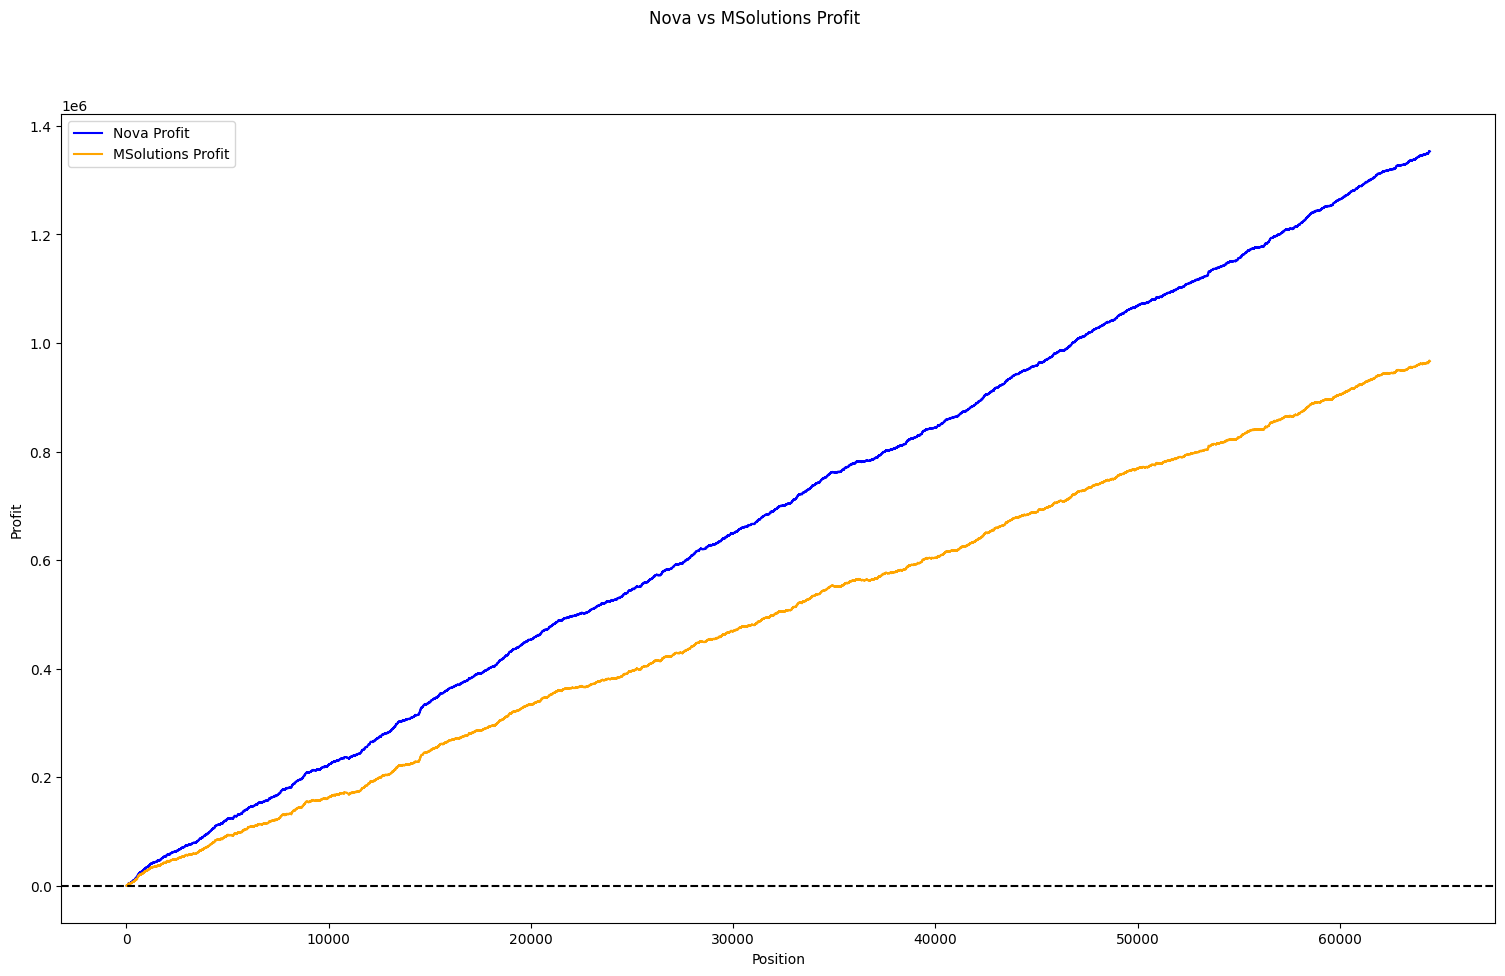

In [260]:
# graph nova_profit_dollars and msolutions_profit_dollars over cum_position_count
fig, ax = plt.subplots()
ax.plot(profit_df['nova_cum_sum'], label='Nova Profit', color='blue')
ax.plot(profit_df['msolutions_cum_sum'], label='MSolutions Profit', color='orange')
# add in a line for 0 
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel('Position')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Profit')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)
# Add legend
ax.legend()
# Show the plot
plt.show()


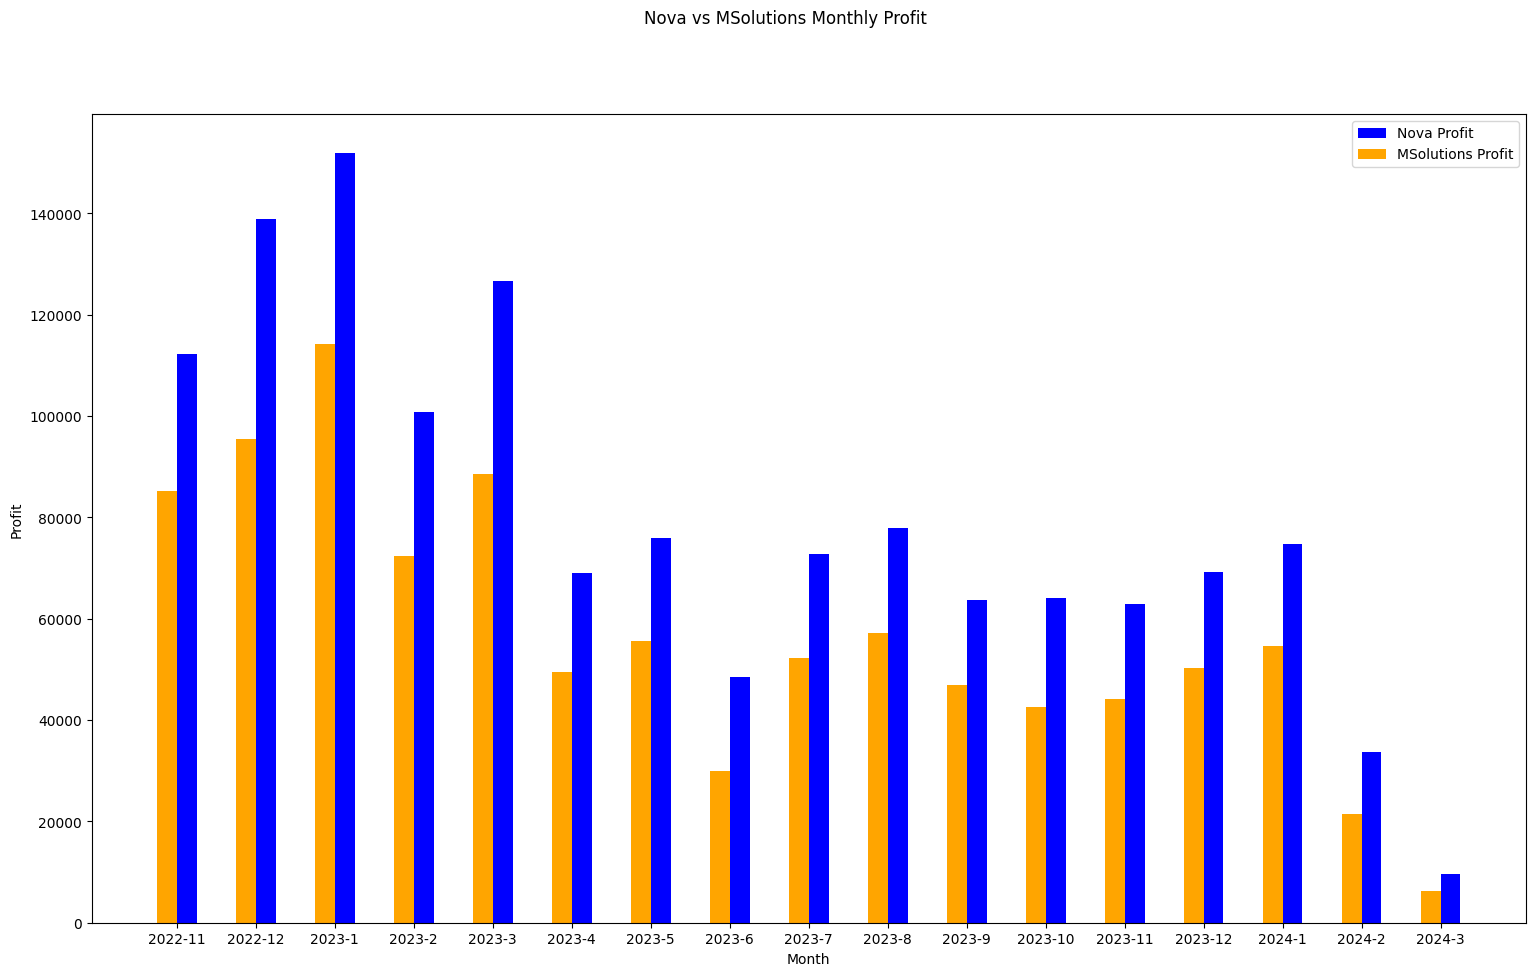

In [261]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_monthly['month'] = profit_df_monthly.index.month
# add a column for the year
profit_df_monthly['year'] = profit_df_monthly.index.year
# concat the year and month like '2023-01'
profit_df_monthly['year_month'] = profit_df_monthly['year'].astype(str) + '-' + profit_df_monthly['month'].astype(str)
# add a column for the month name
profit_df_monthly['month_name'] = profit_df_monthly.index.strftime('%B')
# profit_df_monthly
# reindex the dataframe
profit_df_monthly_reset = profit_df_monthly.reset_index()

# Nova Profit
ax.bar(profit_df_monthly_reset.index + width/4, profit_df_monthly_reset['nova_profit'], label='Nova Profit', color='blue', width=width/2)

# MSolutions Profit
ax.bar(profit_df_monthly_reset.index - width/4, profit_df_monthly_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/2)

# set the x axis labels to be from the column 'year_month'
ax.set_xticks(profit_df_monthly_reset.index)
ax.set_xticklabels(profit_df_monthly_reset['year_month'])

ax.set_xlabel('Month')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Monthly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


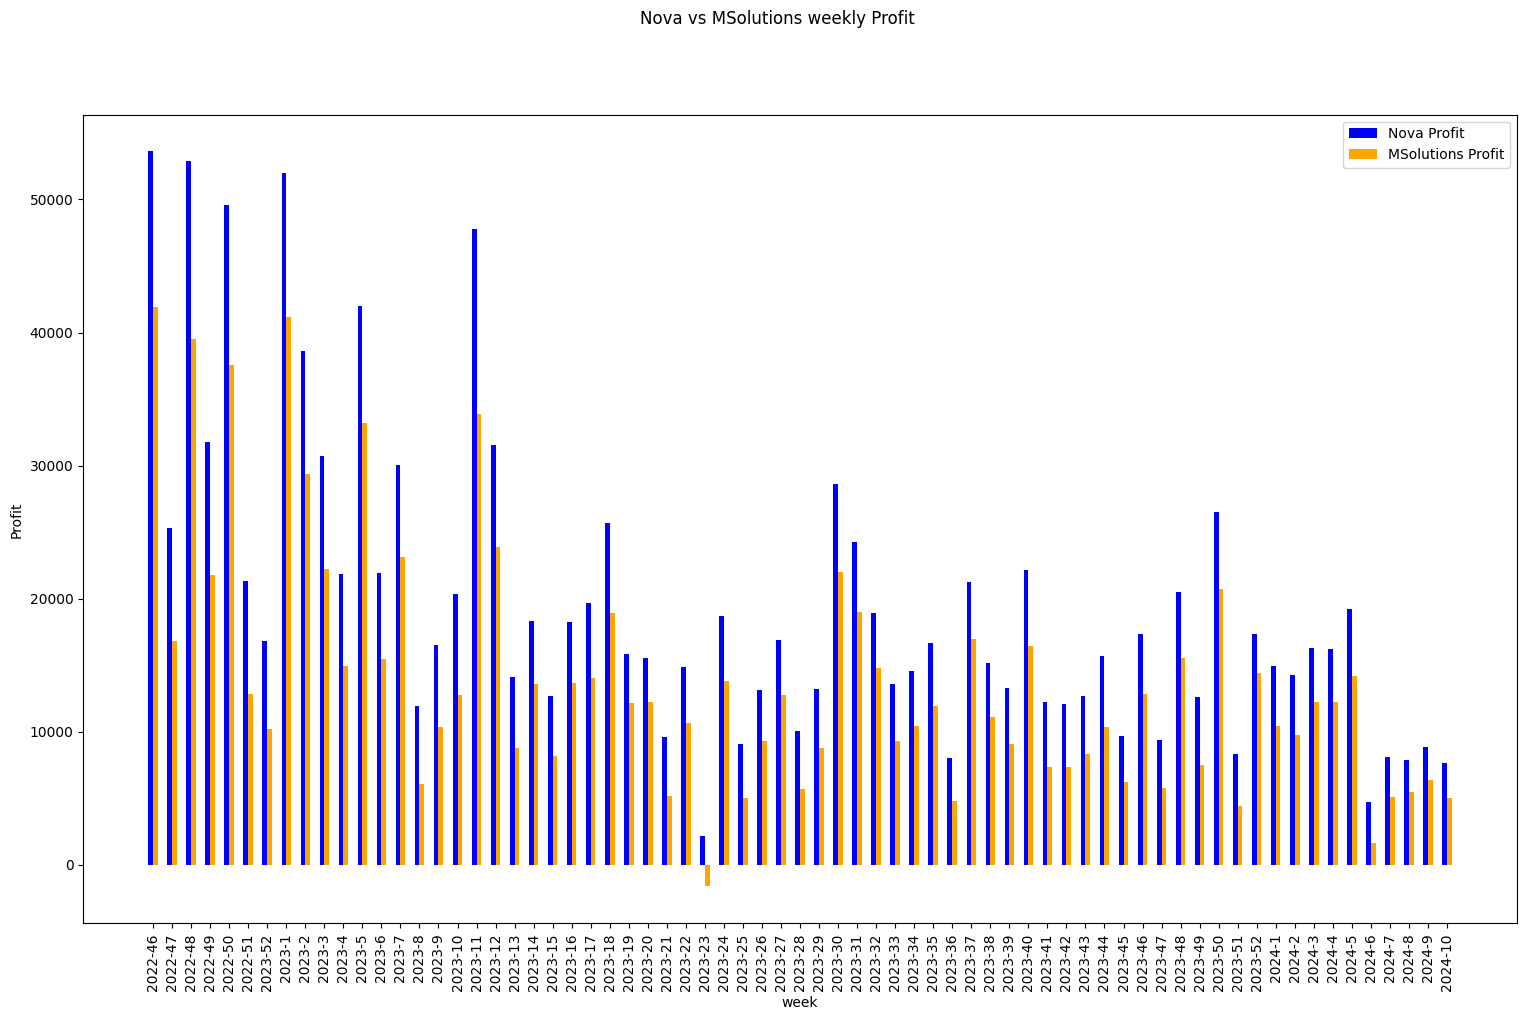

In [262]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_weekly['week'] = profit_df_weekly.index.isocalendar().week
# add a column for the week name
profit_df_weekly['week_name'] = profit_df_weekly.index.strftime('%U')
# convert the week_name to an integer
profit_df_weekly['week_name'] = profit_df_weekly['week_name'].astype(int)
# get the year
profit_df_weekly['year'] = profit_df_weekly.index.year
# concat the year and week like '2023-01'
profit_df_weekly['year_week'] = profit_df_weekly['year'].astype(str) + '-' + profit_df_weekly['week'].astype(str)
# reset the index
profit_df_weekly_reset = profit_df_weekly.reset_index()

# Nova Profit
ax.bar(profit_df_weekly_reset.index - width/4, profit_df_weekly_reset['nova_profit'], label='Nova Profit', color='blue', width=width/2)

# MSolutions Profit
ax.bar(profit_df_weekly_reset.index + width/4, profit_df_weekly_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/2)


# set the x axis labels to be from the column 'year_month'
ax.set_xticks(profit_df_weekly_reset.index)
ax.set_xticklabels(profit_df_weekly_reset['year_week'])
# rotate the x axis labels vertically
plt.xticks(rotation=90)

ax.set_xlabel('week')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions weekly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [263]:
# what is the median of nova_profit
nova_median = profit_df_weekly['nova_profit'].median()
print('Nova Median: ', nova_median)
# what is the average
nova_mean = profit_df_weekly['nova_profit'].mean()
print('Nova Mean: ', nova_mean)

# Nova Median:  5015.969067370917
# Nova Mean:  5628.56341916719

Nova Median:  16507.732931300256
Nova Mean:  19609.111812652354


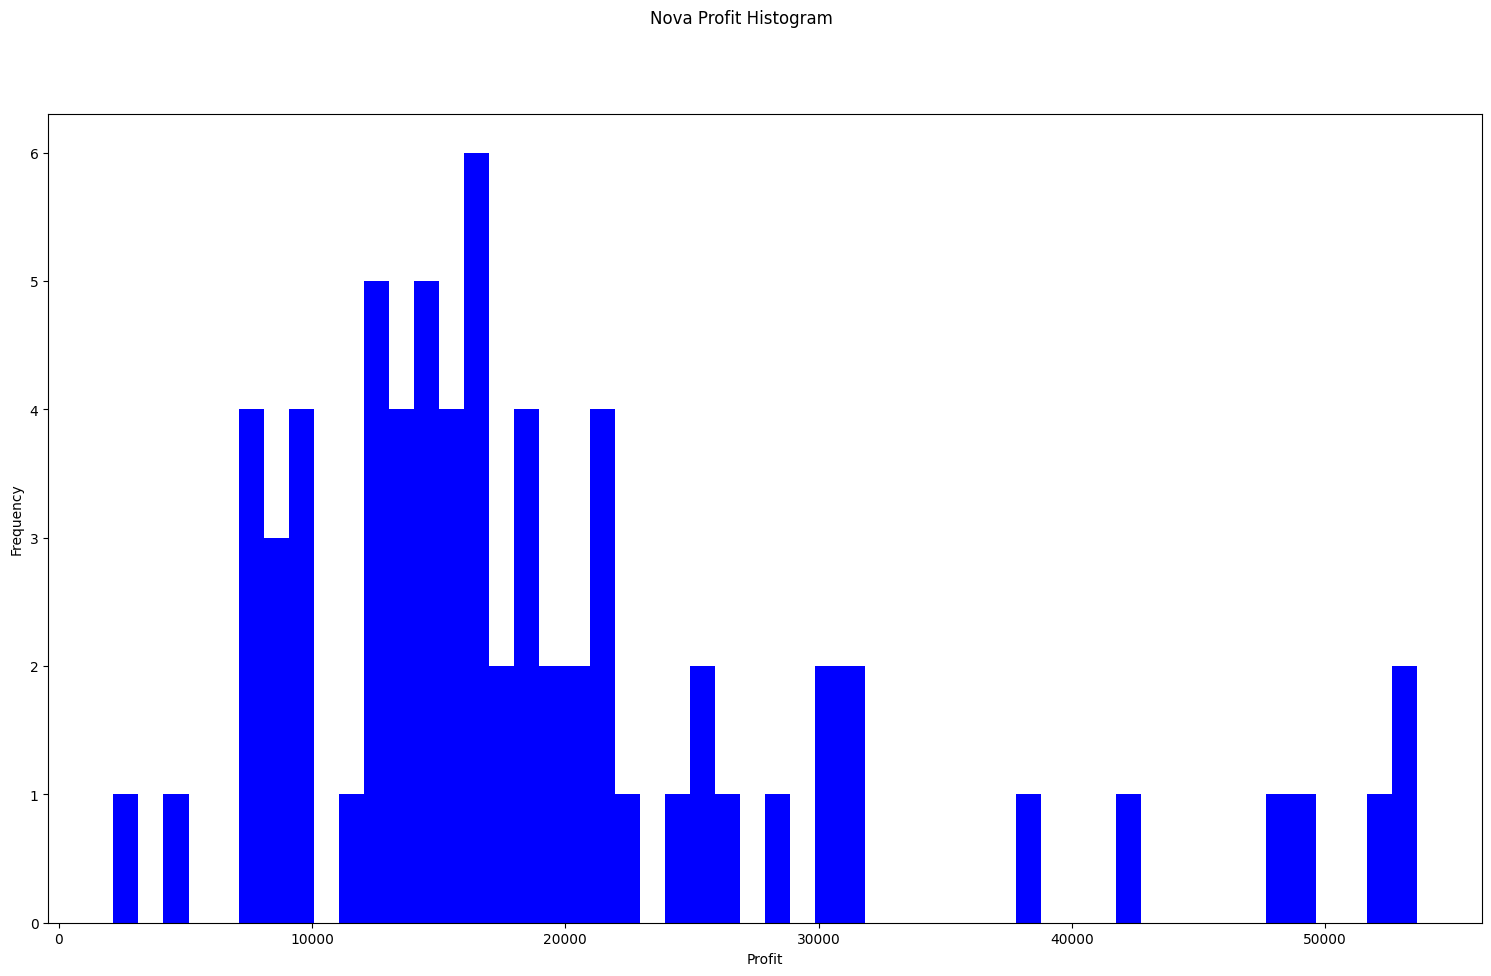

In [264]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_weekly['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


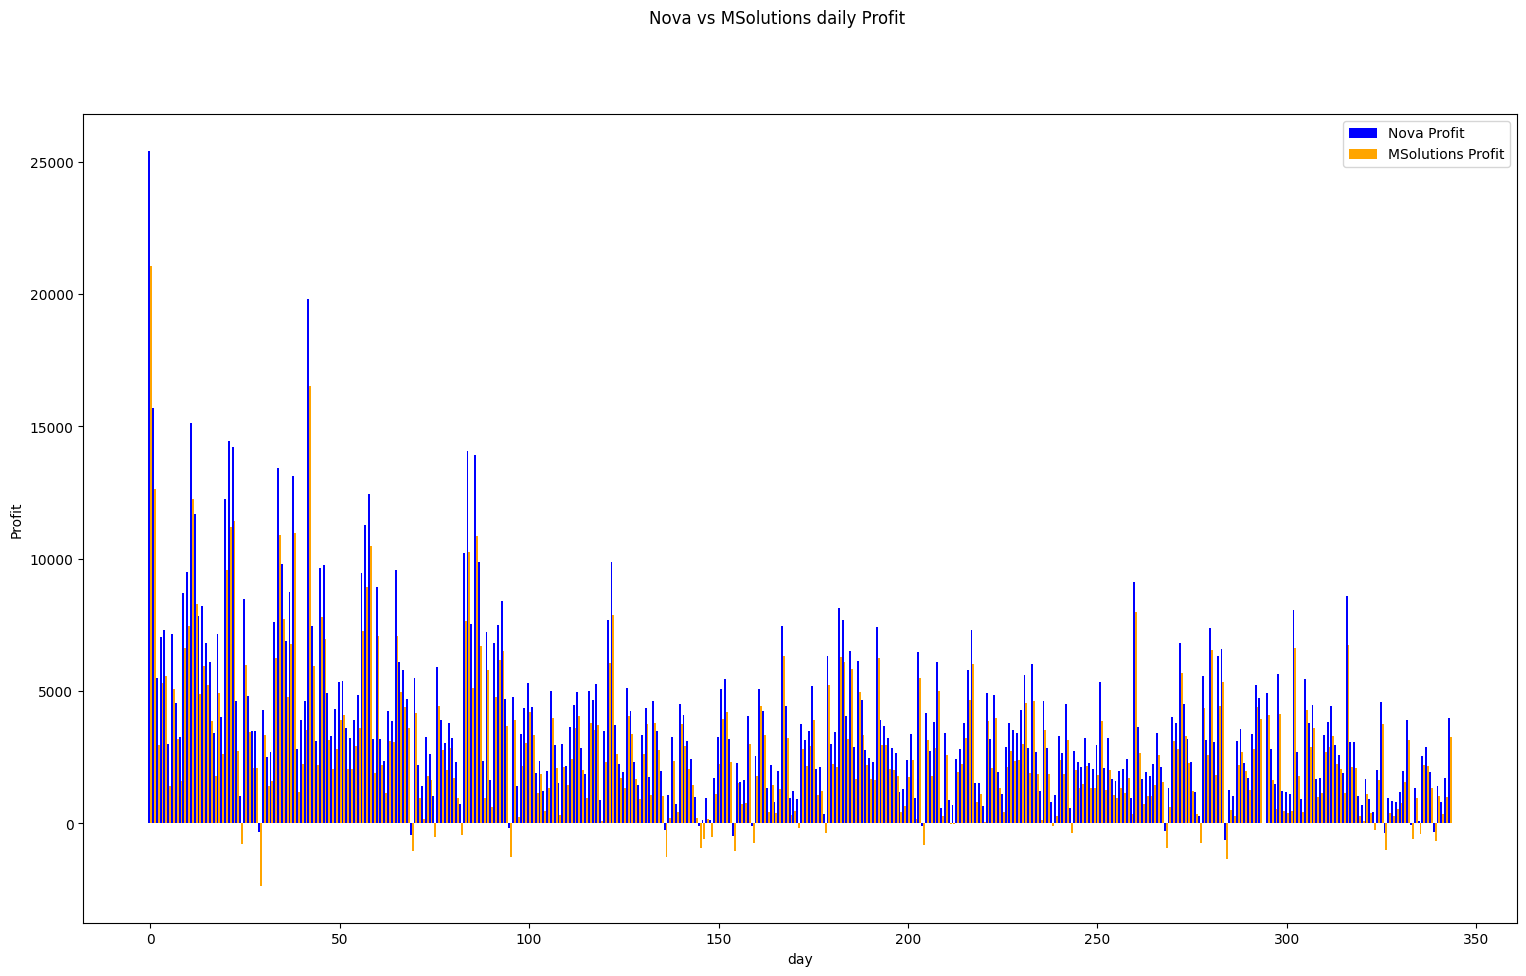

In [265]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily['day_number'] = profit_df_daily.index.dayofyear 
# add a column for the 
profit_df_daily['day_name'] = profit_df_daily.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily['day_name'] = profit_df_daily['day_name'].astype(int)
# reset the index
profit_df_daily_reset = profit_df_daily.reset_index()

# Nova Profit
ax.bar(profit_df_daily_reset.index - width/2, profit_df_daily_reset['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily_reset.index + width/2, profit_df_daily_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


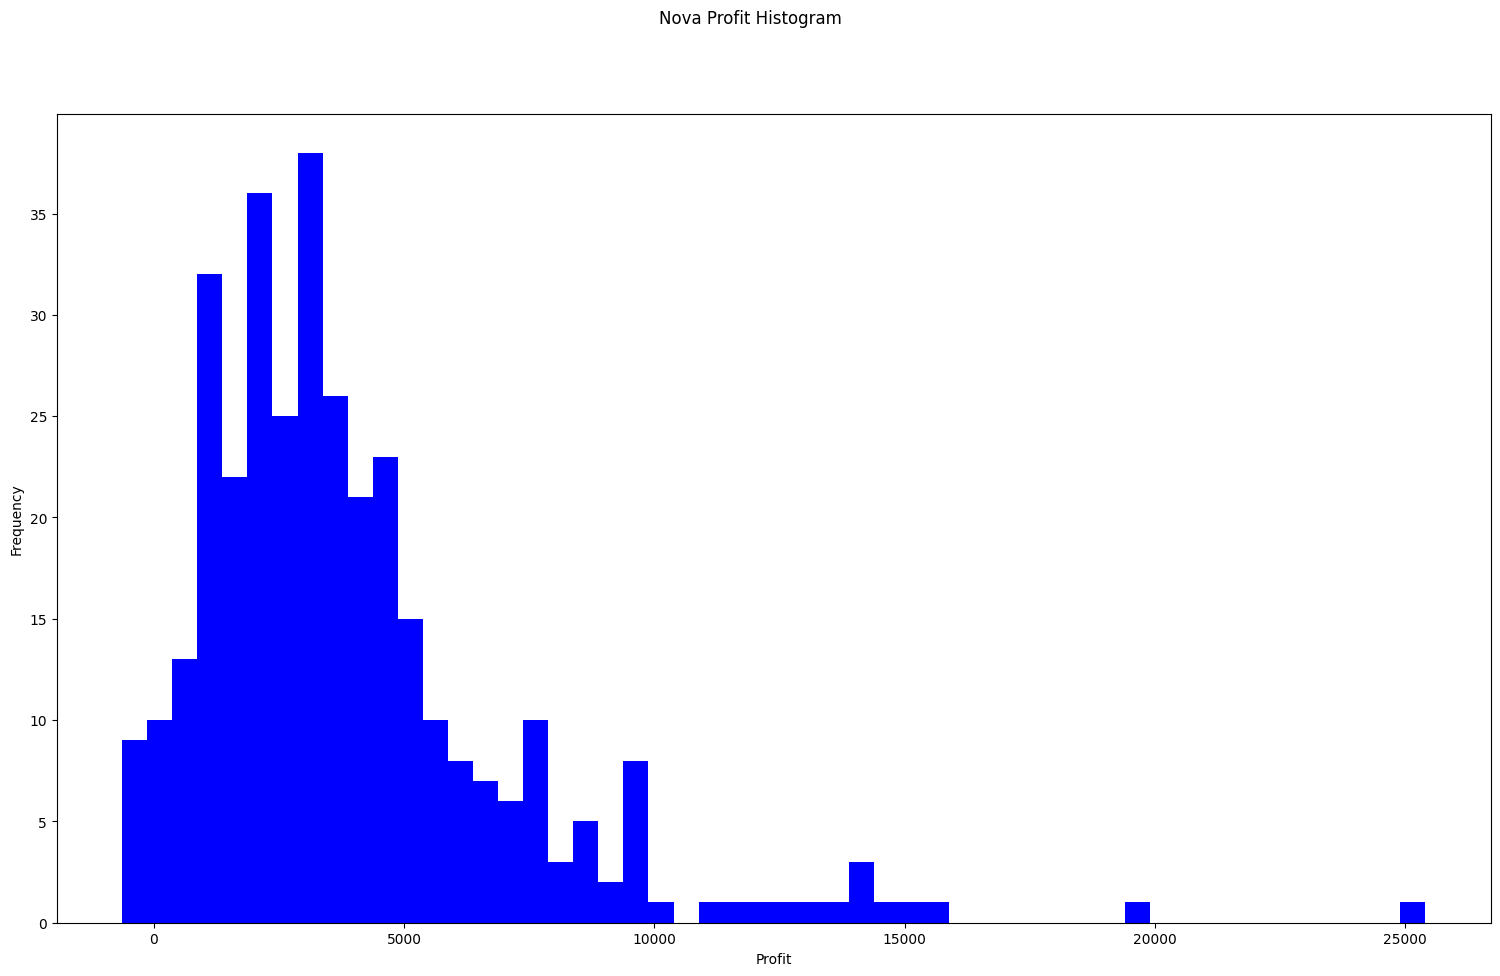

In [266]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_daily['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [267]:
# show the bins and counts from histogram in a table
nova_profit_hist = np.histogram(profit_df_daily['nova_profit'], bins=52)
# put this into a pandas dataframe
nova_profit_hist_df = pd.DataFrame({'bin': nova_profit_hist[1][:-1], 'count': nova_profit_hist[0]})
nova_profit_hist_df


,bin,count
0,-631.521210,9
1,-130.859249,10
2,369.802713,13
3,870.464674,32
4,1371.126635,22
5,1871.788597,36
6,2372.450558,25
7,2873.112519,38
8,3373.774480,26
9,3874.436442,21


In [268]:
# how many entry times were within 5 minutes of 8:30 am
# separate the hours and minutes from the entry_time column
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df['entry_hour'] = profit_df['entry_time'].dt.hour
profit_df['entry_minute'] = profit_df['entry_time'].dt.minute

# if the entry_hour is 8 and the entry_minute is between 25 and 35 then add a column called 'entry_8_30' and set it to 1
profit_df['entry_8_30'] = np.where((profit_df['entry_hour'] == 8) & (profit_df['entry_minute'] >= 25) & (profit_df['entry_minute'] <= 35), 1, 0)
# find the sum of the entry_8_30 column
entry_8_30_count = profit_df['entry_8_30'].sum()
print('Entry 8:30 Count: ', entry_8_30_count)

Entry 8:30 Count:  222


## Hour distribution

In [269]:
# find the win rate grouped by entry_hour
win_rate_by_hour = profit_df.groupby('entry_hour').agg({'nova_profit': lambda x: (x > 0).sum() / x.count()})
win_rate_by_hour

,nova_profit
entry_hour,
0,0.299858
1,0.421729
2,0.468060
3,0.397924
4,0.353549
5,0.383548
6,0.381895
7,0.411842
8,0.399518


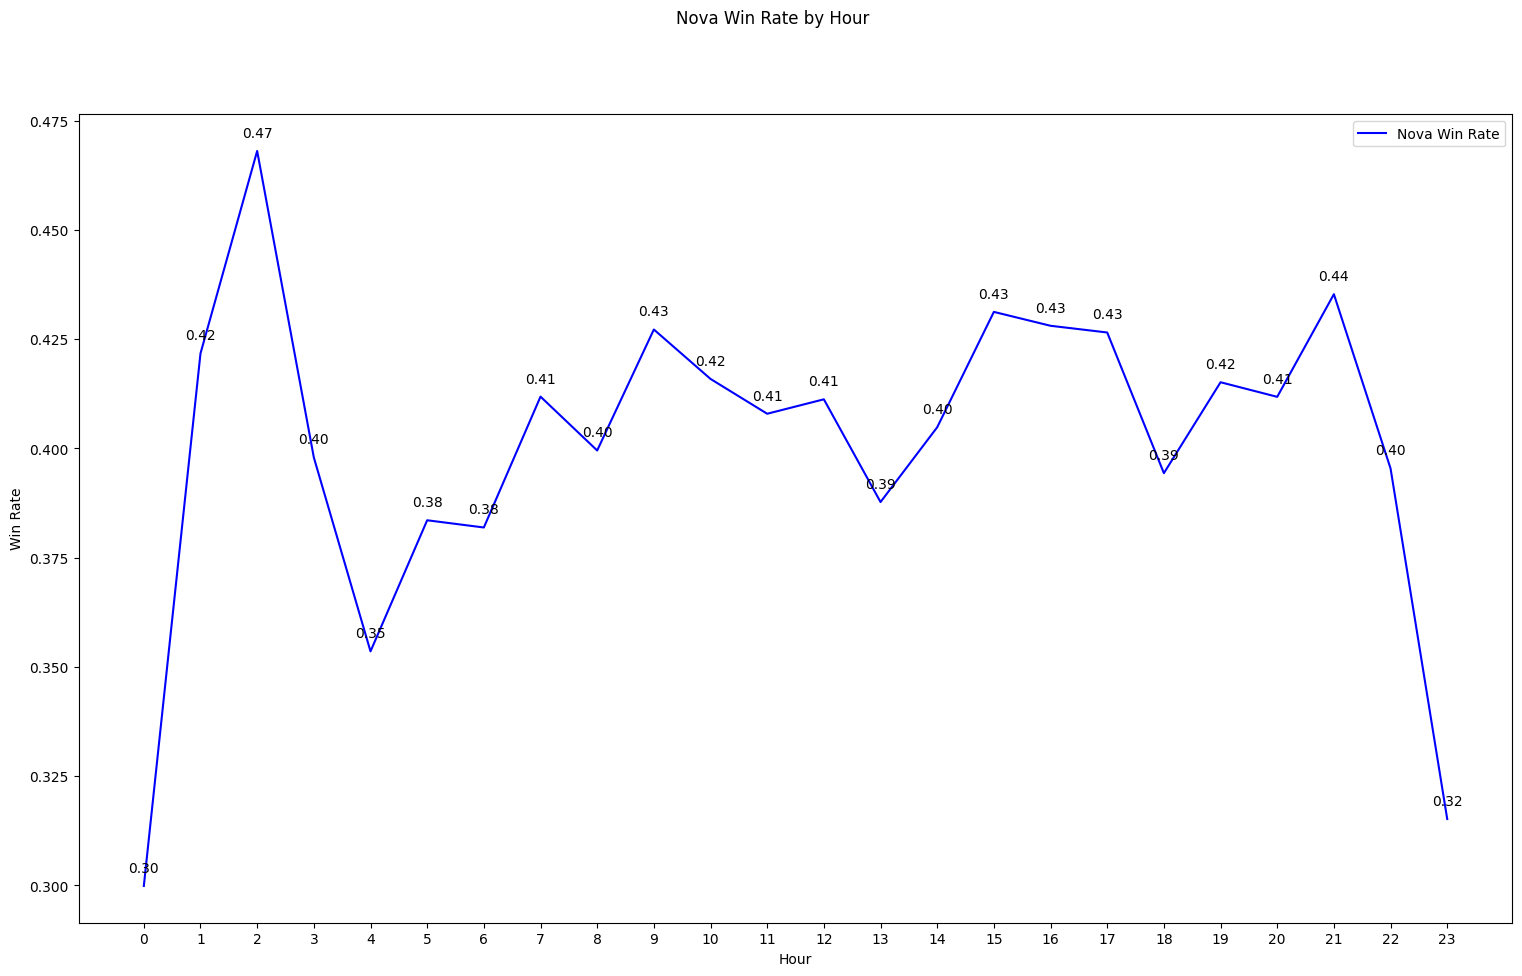

In [270]:
# create a line graph of the win rate by hour
fig, ax = plt.subplots()
ax.plot(win_rate_by_hour.index, win_rate_by_hour['nova_profit'], label='Nova Win Rate', color='blue')
# show the values for x and y next to the points
for i, txt in enumerate(win_rate_by_hour['nova_profit']):
    ax.annotate(f'{txt:.2f}', (win_rate_by_hour.index[i], win_rate_by_hour['nova_profit'][i]), textcoords="offset points", xytext=(0,10), ha='center')
# show all of the ticks on the x axis
ax.set_xticks(win_rate_by_hour.index)
ax.set_xlabel('Hour')
ax.set_ylabel('Win Rate')
fig.suptitle('Nova Win Rate by Hour')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [271]:
# filter out any rows that have entry_hour as 
low_win_perc_hrs = [0,23] #20, 21,
low_win_perc_removed = profit_df[~profit_df.entry_hour.isin(low_win_perc_hrs)]
# find the sum of nova profit for low_win_perc_removed
print(low_win_perc_removed['nova_profit'].sum(), profit_df['nova_profit'].sum())
# 450,269.5324621328 436,764.53246210545 (0,7,22,23)
# 447,864.53246212745 436,764.53246210545 - nighttime hours (0,22,23)


1352575.7150730144 1353028.7150730123


In [272]:
# export the profit_df to a csv
# profit_df.to_csv('profit_df.csv')